In [1]:
from RCGP.rcgp.rcgp import RCGPR
from RCGP.rcgp.rcsvgp import RCSGPR
import matplotlib.pyplot as plt 
import numpy as np 
import tqdm
import gpflow as gpf
from RCGP.rcgp.w import IMQ

2025-05-02 15:16:50.764033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 15:16:50.768032: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 15:16:50.817740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 15:16:50.817832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 15:16:50.819992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def plot_model(model: gpf.models.GPModel, plot=True) -> None:
    X, Y = model.data
    opt = gpf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    if plot:
        gpf.utilities.print_summary(model, "notebook")

        Xplot = np.linspace(0.0, len(Y), len(Y))[:, None]

        y_mean, y_var = model.predict_y(Xplot, full_cov=False)
        y_lower = y_mean - 1.96 * np.sqrt(y_var)
        y_upper = y_mean + 1.96 * np.sqrt(y_var)

        _, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(X, Y, "kx", mew=2)
        (mean_line,) = ax.plot(Xplot, y_mean, "-")
        color = mean_line.get_color()
        ax.plot(Xplot, y_lower, lw=0.1, color=color)
        ax.plot(Xplot, y_upper, lw=0.1, color=color)
        ax.fill_between(
            Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color=color, alpha=0.1
        )
        plt.xlabel("t")
        plt.ylabel("y")
        plt.title(model.name)
        
        # Also plot the inducing variables if possible:
        iv = getattr(model, "inducing_variable", None)
        if iv is not None:
            ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")

### Can we LRT changepoints with this?

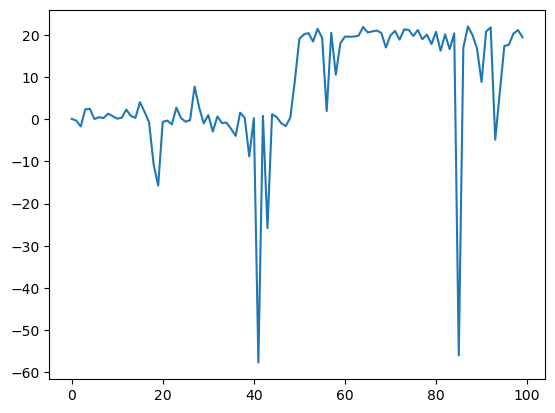

In [27]:
y = np.random.standard_t(1, size=100).reshape(-1, 1)
y[int(len(y)/2):] = y[int(len(y)/2):] + 20
X = np.arange(len(y)).astype(float).reshape(-1, 1)

plt.plot(X, y)
plt.show()

In [28]:
model = RCGPR((X, y), weighting_function=IMQ(C=np.quantile(np.abs(y), 0.7)), kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.Constant() for i in range(2)], locations=[15], steepness=10))

name,class,transform,prior,trainable,shape,dtype,value
RCGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0
RCGPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,19.60124
RCGPR.kernel.locations,Parameter,Identity,,True,"(1,)",float64,[48.98505]
RCGPR.kernel.steepness,Parameter,Softplus,,True,(),float64,11.89582
RCGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,110.86379
RCGPR.weighting_function.C,Parameter,Softplus,,True,(),float64,11.57099


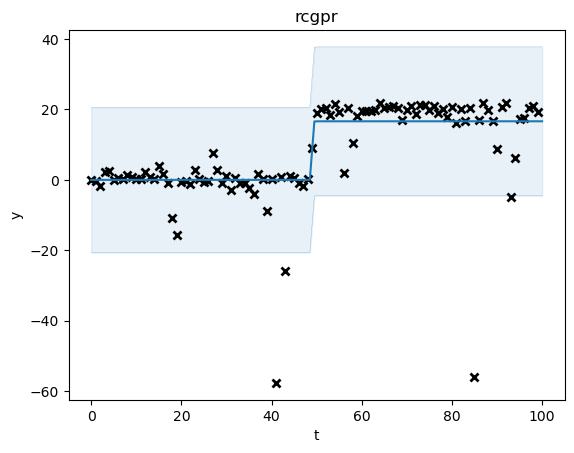

100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


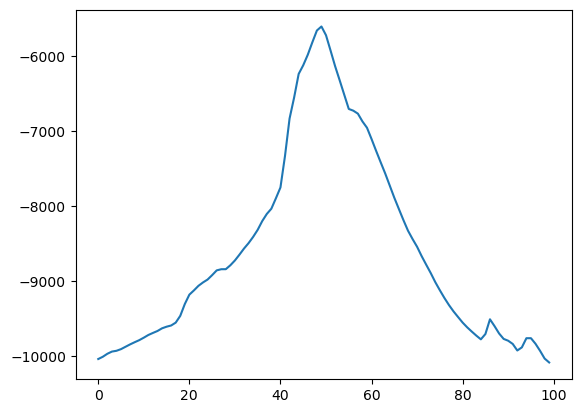

In [29]:
model = RCGPR((X, y), weighting_function=IMQ(C=np.quantile(np.abs(y), 0.7)), kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.Constant() for i in range(2)], locations=[15], steepness=10))
plot_model(model)
plt.show()

llob = []
for loc in tqdm.tqdm(range(0, len(X))):
    model = RCGPR((X, y), weighting_function=IMQ(C=np.quantile(np.abs(y), 0.7)), kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.Constant() for i in range(2)], locations=[loc], steepness=10))
    llob.append(model.maximum_log_likelihood_objective())
plt.plot(llob)
    

name,class,transform,prior,trainable,shape,dtype,value
RCSGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.87401
RCSGPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.04567
RCSGPR.kernel.locations,Parameter,Identity,,True,"(1,)",float64,[15.60267]
RCSGPR.kernel.steepness,Parameter,Softplus,,True,(),float64,10.00799
RCSGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,31.88136
RCSGPR.inducing_variable.Z,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
RCSGPR.weighting_function.C,Parameter,Softplus,,True,(),float64,0.0


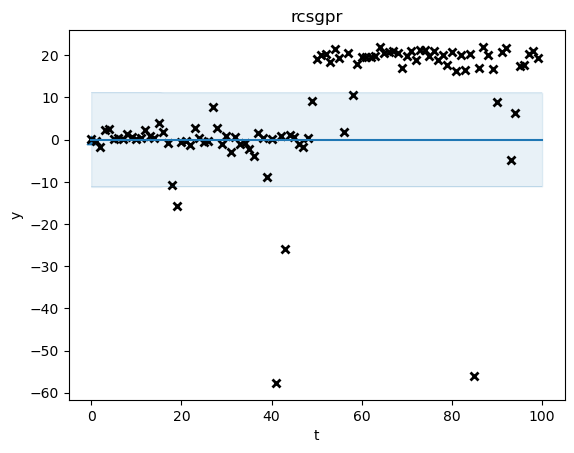

100%|██████████| 100/100 [00:04<00:00, 22.48it/s]


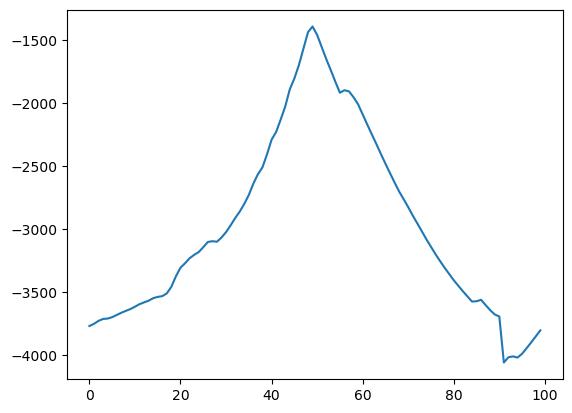

In [36]:

model = RCSGPR((X, y), inducing_variable=np.arange(0, 10, 100).reshape(-1, 1), weighting_function=IMQ(C=np.quantile(np.abs(y), 0.7)), kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.Constant() for i in range(2)], locations=[15], steepness=10))
plot_model(model)
plt.show()

llob = []
for loc in tqdm.tqdm(range(0, len(X))):
    model = RCSGPR((X, y), inducing_variable=np.arange(0, 100, 10).reshape(-1, 1), weighting_function=IMQ(C=np.quantile(np.abs(y), 0.7)), kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.Constant() for i in range(2)], locations=[loc], steepness=10))
    llob.append(model.maximum_log_likelihood_objective())
plt.plot(llob)

100%|██████████| 100/100 [00:02<00:00, 45.24it/s]


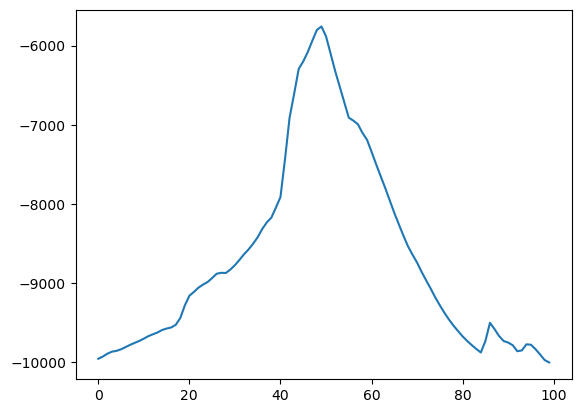

In [31]:
llob = []
for loc in tqdm.tqdm(range(0, len(X))):
    k = gpf.kernels.ChangePoints([gpf.kernels.Constant() for i in range(2)], locations=[loc], steepness=100)
    gpr = gpf.models.GPR((X, y), kernel=k)
    llob.append(gpr.maximum_log_likelihood_objective())
plt.plot(llob)

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,9e-05
SGPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,93.23437
SGPR.kernel.locations,Parameter,Identity,,True,"(1,)",float64,[22.12145]
SGPR.kernel.steepness,Parameter,Softplus,,True,(),float64,100.03898
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,179.83956
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(20, 1)",float64,[[45....


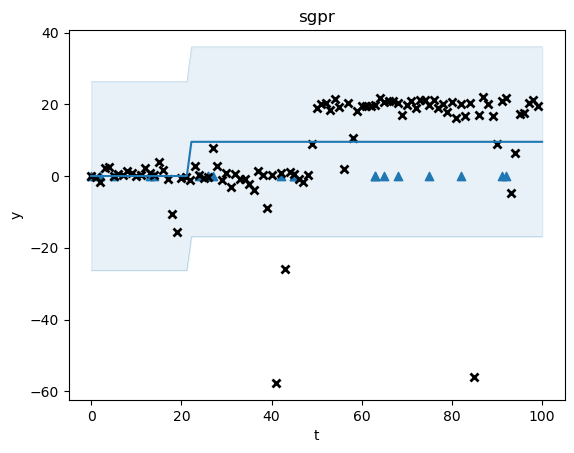

100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


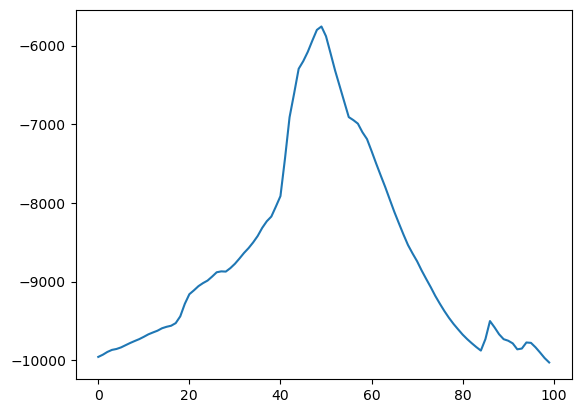

In [37]:
k2 = gpf.kernels.ChangePoints([gpf.kernels.Constant() for i in range(2)], locations=[50], steepness=100)
sgpr = gpf.models.SGPR((X, y), kernel=k2, inducing_variable=np.random.choice(X.flatten(), 20).reshape(-1, 1))

plot_model(sgpr)
sgpr.maximum_log_likelihood_objective()
plt.show()
llob = []
for loc in tqdm.tqdm(range(0, len(X))):
    k = gpf.kernels.ChangePoints([gpf.kernels.Constant() for i in range(2)], locations=[loc], steepness=10)
    sgpr = gpf.models.SGPR((X, y), kernel=k, inducing_variable=np.random.choice(X.flatten(), 40).reshape(-1, 1))
    llob.append(sgpr.maximum_log_likelihood_objective())
plt.plot(llob)

100%|██████████| 100/100 [00:04<00:00, 20.97it/s]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 401.9604184527167
        x: [ 9.873e-01 -1.273e-05 ...  5.424e-01  1.028e+01]
      nit: 29
      jac: [-2.055e-04 -9.514e-05 ...  6.341e-30  7.907e-05]
     nfev: 31
     njev: 31
 hess_inv: <530x530 LbfgsInvHessProduct with dtype=float64>

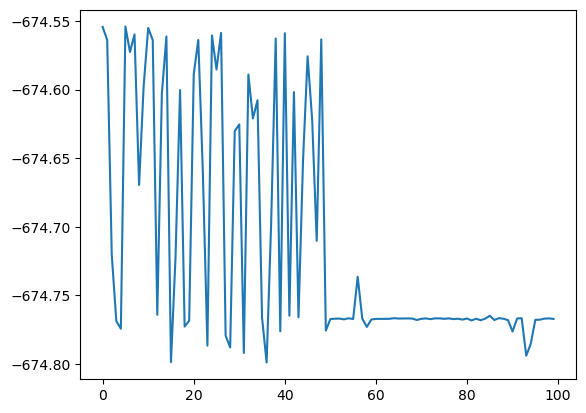

In [33]:
model = gpf.models.SVGP(
    kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.Constant() for i in range(2)], locations=[20], steepness=[10]),
    likelihood=gpf.likelihoods.StudentT(),
    inducing_variable=np.random.choice(X.flatten(), 20).reshape(-1, 1)
)
opt = gpf.optimizers.Scipy()
opt.minimize(model.training_loss_closure((X, y)), model.trainable_variables)

llob = []
for loc in tqdm.tqdm(range(0, len(X))):
    k = gpf.kernels.ChangePoints([gpf.kernels.Constant() for i in range(2)], locations=[loc], steepness=10)
    svgp = gpf.models.SVGP(kernel=k, likelihood=gpf.likelihoods.StudentT(), inducing_variable=np.random.choice(X.flatten(), 30).reshape(-1, 1))
    llob.append(svgp.maximum_log_likelihood_objective((X, y)))
plt.plot(llob)

opt = gpf.optimizers.Scipy()
opt.minimize(svgp.training_loss_closure((X, y)), svgp.trainable_variables)

╒═════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                            │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞═════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ SVGP.kernel.kernels[0].variance │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 0.0                                      │
├─────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].variance │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 268.55707                                │
├─────────────────────────────────┼───────────┼─────

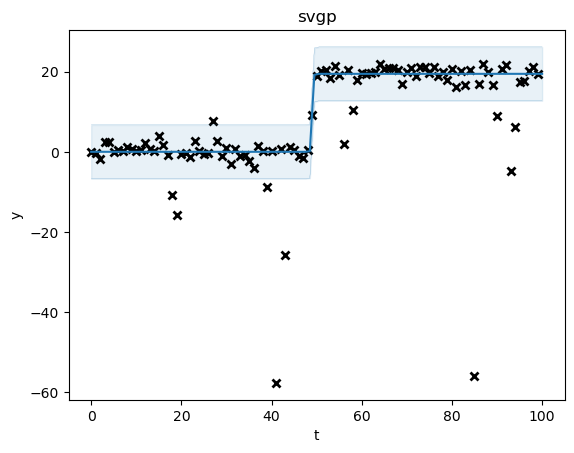

In [34]:

Xplot = np.linspace(0.0, len(y), len(y))[:, None]

y_mean, y_var = model.predict_y(Xplot, full_cov=False)
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

_, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(X, y, "kx", mew=2)
(mean_line,) = ax.plot(Xplot, y_mean, "-")
color = mean_line.get_color()
ax.plot(Xplot, y_lower, lw=0.1, color=color)
ax.plot(Xplot, y_upper, lw=0.1, color=color)
ax.fill_between(
    Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color=color, alpha=0.1
)
plt.xlabel("t")
plt.ylabel("y")
plt.title(model.name)

# Also plot the inducing variables if possible:
# iv = getattr(model, "inducing_variable", None)
# if iv is not None:
#     ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")
gpf.utilities.print_summary(model)